# https://arxiv.org/pdf/2008.08400.pdf

In [1]:
from src.models import Exponential_Model
from src.criterion import right_censored,RightCensorWrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import visualize_population_curves_attacked,visualize_individual_curves_attacked

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
from backpack import backpack, extend, memory_cleanup
from backpack.extensions import DiagGGNExact, DiagGGNMC, KFAC, KFLR, SumGradSquared, BatchGrad
from backpack.context import CTX

In [3]:
def _cleanup(module):
    for child in module.children():
        _cleanup(child)

    setattr(module, "_backpack_extend", False)
    memory_cleanup(module)

In [4]:
class ARGS(object):
    def __init__(self):
        pass

In [5]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=100
args.lr = 1e-3
args.batch_size= 128
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=10,length=20"
args.hidden_dims = [15,15]
args.save_model = ""
args.dataset = "TRACE"


In [6]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [7]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [8]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([1502, 10])

In [9]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))


# model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(RightCensorWrapper(clf_robust),dataset_train.tensors)
model_fragile_wrap = BoundedModule(RightCensorWrapper(clf_fragile),dataset_train.tensors)

In [10]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=562.4500 Time=0.0030
[ 1:  10]: eps=0.00000000 Loss=558.8430 Time=0.0023
[ 1:  11]: eps=0.00000000 Loss=549.9137 Time=0.0022
Epoch time: 0.0386, Total time: 0.0386
Evaluating...
[ 1:   2]: eps=0.00000000 Loss=527.6398 Time=0.0010
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=538.7404 Time=0.0020
[ 2:  10]: eps=0.00000000 Loss=525.2426 Time=0.0020
[ 2:  11]: eps=0.00000000 Loss=515.9268 Time=0.0020
Epoch time: 0.0310, Total time: 0.0696
Evaluating...
[ 2:   2]: eps=0.00000000 Loss=495.6182 Time=0.0010
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=541.2810 Time=0.0020
[ 3:  10]: eps=0.00000000 Loss=495.5899 Time=0.0017
[ 3:  11]: eps=0.00000000 Loss=486.1679 Time=0.0017
Epoch time: 0.0280, Total time: 0.0977
Evaluating...
[ 3:   2]: eps=0.00000000 Loss=465.8111 Time=0.0010
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=506.9294 Time=0.0020
[ 4:  10]: eps=0.00000000 Loss=463.5049 T

<Figure size 1000x1000 with 0 Axes>

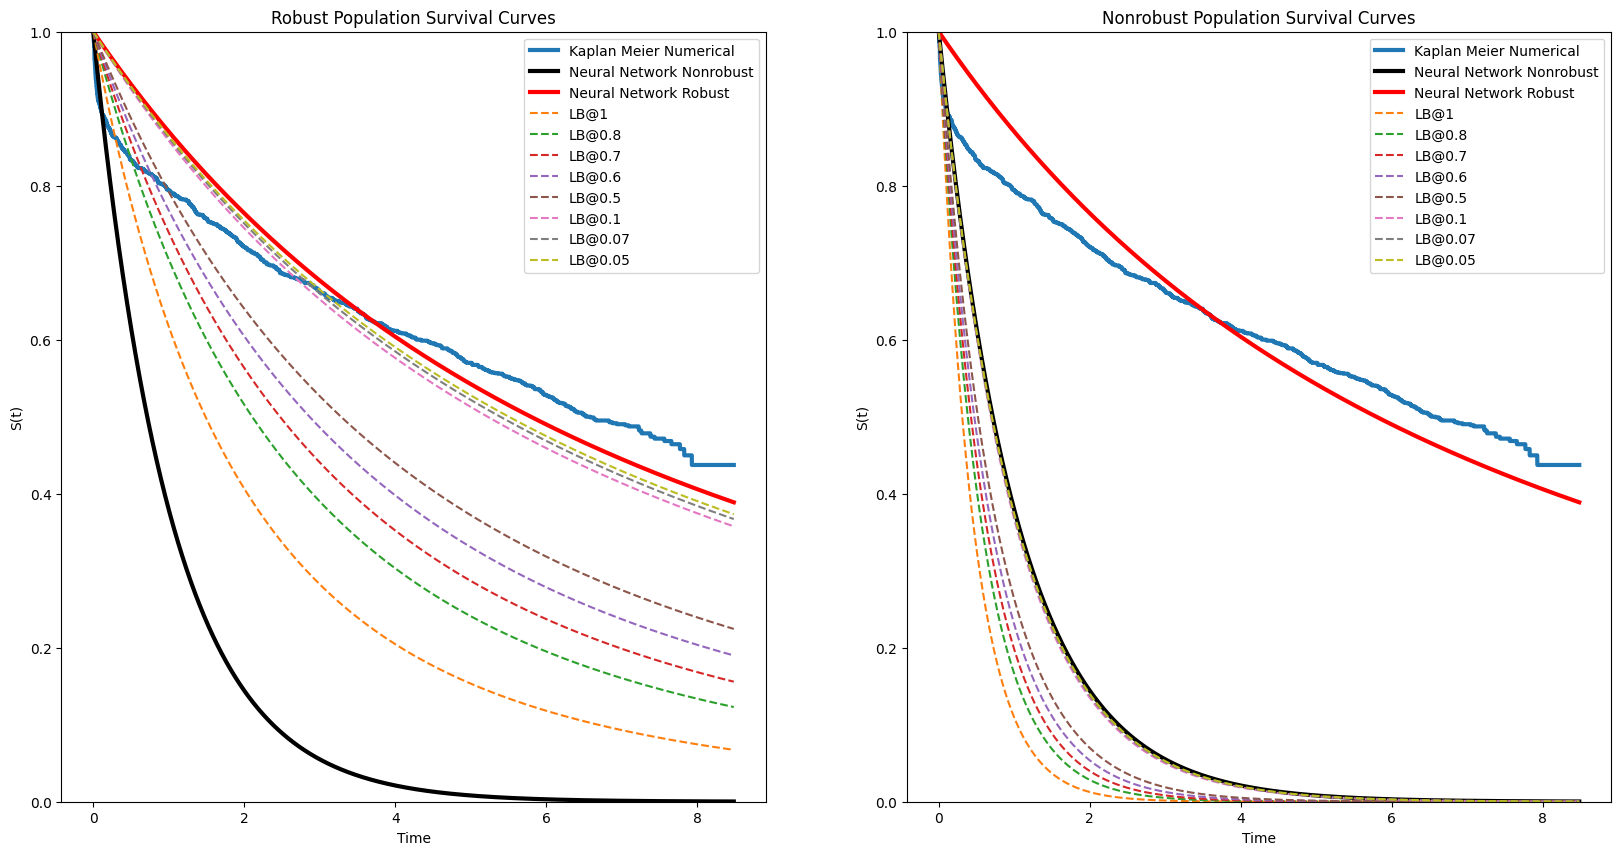

In [11]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons)

In [12]:
clf_renewed = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_renewed.load_state_dict(clf_robust.state_dict())

<All keys matched successfully>

In [13]:
def input_noise_wrapper(t,e):
    def input_noise(f):
    
        log_exact = e * torch.log(f) + e * -(t * f)
        log_right = (1 - e) * -(f * t)
    
        return (log_exact + log_right).sum()

    return input_noise


In [ ]:
def jacobians(model,x,subnetwork_indices=None):
    """Compute Jacobians \\(\\nabla_{\\theta} f(x;\\theta)\\) at current parameter \\(\\theta\\)
    using backpack's BatchGrad per output dimension.

    Parameters
    ----------
    x : torch.Tensor
        input data `(batch, input_shape)` on compatible device with model.
    enable_backprop : bool, default = False
        whether to enable backprop through the Js and f w.r.t. x

    Returns
    -------
    Js : torch.Tensor
        Jacobians `(batch, parameters, outputs)`
    f : torch.Tensor
        output function `(batch, outputs)`
    """
    model = extend(model)
    to_stack = []
    for i in range(model.output_size):
        model.zero_grad()
        out = model(x)
        with backpack(BatchGrad()):
            if model.output_size > 1:
                out[:, i].sum().backward(
                    create_graph=False, 
                    retain_graph=False
                )
            else:
                out.sum().backward(
                    create_graph=False, 
                    retain_graph=False
                )
            to_cat = []
            for param in model.parameters():
                to_cat.append(param.grad_batch.reshape(x.shape[0], -1))
                delattr(param, 'grad_batch')
            Jk = torch.cat(to_cat, dim=1)
            if subnetwork_indices is not None:
                Jk = Jk[:, self.subnetwork_indices]
        to_stack.append(Jk)
        if i == 0:
            f = out

    model.zero_grad()
    CTX.remove_hooks()
    _cleanup(model)
    if model.output_size > 1:
        return torch.stack(to_stack, dim=2).transpose(1, 2), f
    else:
        return Jk.unsqueeze(-1).transpose(1, 2), f

In [ ]:
clf_renewed.output_size=1
clf_robust.output_size=1

In [15]:
X_train,T_train,E_train = dataloader_train.dataset.tensors

In [ ]:
feature_jacobian_matrix,f = jacobians(clf_renewed,X_train)

In [ ]:
clf_renewed.zero_grad()
clf_renewed(X_train[[1]]).sum().backward()

In [ ]:
for param in clf_renewed.parameters():
    print(param.grad.ravel())

In [ ]:
feature_jacobian_matrix[1]

In [ ]:
feature_jacobian_matrix=feature_jacobian_matrix.squeeze()

In [ ]:
import torch

input_noise = input_noise_wrapper(T_train,E_train)

In [ ]:
f = clf_renewed(X_train)

In [ ]:
np.allclose(GGN, GGN.T, rtol=1e-4, atol=1e-5)

In [ ]:
np.abs(GGN-GGN.T).max()

In [ ]:
input_noise_matrix = -torch.autograd.functional.hessian(input_noise,f,strict=True).squeeze()

In [ ]:
GGN = torch.einsum("ij,jk,kl->il",feature_jacobian_matrix.T,input_noise_matrix,feature_jacobian_matrix)

In [ ]:
L = torch.linalg.cholesky_ex(GGN).L

In [ ]:
GGN

In [ ]:
L@L.T

In [ ]:
# torch.nn.utils.parameters_to_vector(clf_robust.parameters())

In [ ]:
plt.imshow(GGN,cmap="jet")

In [ ]:
cov = torch.linalg.inv(GGN + torch.eye(GGN.shape[0])*1)

In [ ]:
np.linalg.eigvals(cov)[230]

In [ ]:
from torch.distributions.multivariate_normal import _precision_to_scale_tril

In [ ]:
plt.imshow(GGN,cmap="jet")

In [ ]:
plt.imshow(cov,cmap="jet")

In [ ]:
torch.linalg.eigvals

In [ ]:
lowert = _precision_to_scale_tril(cov)

# perform cholesky inverse to get the full covariance matrix
# cov = torch.cholesky_inverse(chol)
cov = lowert @ lowert.T

In [ ]:
np.linalg.cholesky(cov)

In [18]:
import torch.nn as nn

In [20]:
class _Loss(nn.Module):

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

In [21]:
class RHS(_Loss):
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)

    def forward(self, rate,t,event):
        return right_censored(rate, t, event)

In [23]:
from torch.nn import CrossEntropyLoss, Linear
from backpack.utils.examples import load_one_batch_mnist
from backpack import extend, backpack
from backpack.extensions import KFAC

model = extend(clf_renewed)
lossfunc = extend(RHS())
loss = lossfunc(model(X_train), T_train,E_train)

with backpack(KFAC()):
    loss.backward()

for param in model.parameters():
    print(param.grad)
    print(param.kfac)

NotImplementedError: Extension saving to kfac does not have an extension for Module <class '__main__.RHS'>